# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей применяйте метрику RMSE.

Значение метрики RMSE должно быть меньше 2500.

## Подготовка данных

### Загрузка модулей

In [2]:
import time
import pandas as pd
import optuna
import plotly

#from pandas_profiling import ProfileReport
#import sweetviz as sv

from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn import svm

from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")

### Настройки

In [3]:
RANDOM_STATE = 12345
state = np.random.RandomState(RANDOM_STATE)
# Цветовая палитра документа
cm = 'crest'
mec = 'gray'
alpha = 0.7
fontsize = 16
figsize_base = 5

def new_color(x='r'):
    '''Цвет графиков, по умолчанию случайный из заданной цветовой палитры. Принимает в качестве аргумента число, \
    соответствующее цвету в палитре.'''
    if x == 'r':
        return list(sns.color_palette(cm, 20)[random.randint(0,19)])
    return list(sns.color_palette(cm, 20)[x])
# Размеры

def figsize(width = 1, height=1):
    '''Задание размеров окна отрисовки.'''
    return (width*figsize_base, height*figsize_base)

# Отрисовка 
def plot_set(ax,title='',xlabel='',ylabel='',fontsize=fontsize,xrot=True,figsize=figsize()):
    '''Функция для отрисовки дополнительных параметров графиков. Подписьи осей и названия, размер шрифта и размер окна, 
    включение сетки.'''
    plt.xticks(rotation=90*int(xrot), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(title+'\n', fontsize=fontsize)
    plt.xlabel('\n'+xlabel, fontsize=fontsize)
    plt.ylabel(ylabel+'\n', fontsize=fontsize)
    plt.grid(True)
    None
    
def mean_percent(x):
    '''Функция для форматирования значений. Округление до сотых и знак процента.'''
    try:
        return "{0:.2%}".format(x)
    except:
        return x

### Загрузка данных

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [5]:
df.head(25)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [6]:
#profile = ProfileReport(df)
#profile.to_widgets()

In [7]:
#report = sv.analyze([df, 'Unique ids and roles'])
#report.show_notebook()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
df.isna().mean().sort_values().apply(mean_percent)

DateCrawled           0.00%
Price                 0.00%
RegistrationYear      0.00%
Power                 0.00%
Kilometer             0.00%
RegistrationMonth     0.00%
Brand                 0.00%
DateCreated           0.00%
NumberOfPictures      0.00%
PostalCode            0.00%
LastSeen              0.00%
Model                 5.56%
Gearbox               5.60%
FuelType              9.28%
VehicleType          10.58%
Repaired             20.08%
dtype: object

In [11]:
df.duplicated().sum()

4

### Вывод этапа

Изучен датафрейм `Churn.csv`:
- 16 столбцов:
    - `DateCrawled` - дата скачивания анкеты из базы
    - `VehicleType` - тип автомобильного кузова
    - `RegistrationYear` - год регистрации автомобиля
    - `Gearbox` - тип коробки передач
    - `Power` - мощность (л. с.)
    - `Model` - модель автомобиля
    - `Kilometer` - пробег (км)
    - `RegistrationMonth` - месяц регистрации автомобиля
    - `FuelType` - тип топлива
    - `Brand` - марка автомобиля
    - `Repaired` - была машина в ремонте или нет
    - `DateCreated` - дата создания анкеты
    - `NumberOfPictures` - количество фотографий автомобиля
    - `PostalCode` - почтовый индекс владельца анкеты (пользователя)
    - `LastSeen` - дата последней активности пользователя
    - `Price` - цена (евро)
- 354369 строк
- Пропуски в строках:
    - `Model` - `5.56%`
    - `Gearbox` - `5.60%`
    - `FuelType` - `9.28%`
    - `VehicleType` - `10.58%`
    - `Repaired` - `20.08%`
- Наблюдаются дубликаты
- Типы всех столбцов корректны

## Предобработка данных

### Изменение данных

Удалим дубликаты

In [12]:
df = df.drop_duplicates()

Удалим столбцы `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`,`PostalCode`.

In [13]:
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

Изменим значение `gasoline` на `petrol` в столбце `FuelType`, поскольку это один и тот же тип топлива.

In [14]:
df.loc[df['FuelType']=='gasoline','FuelType'] = 'petrol'

### Изучение данных

Рассмотрим распределение данных.

In [15]:
num_columns = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
num_columns_name = ['Года регистрации', 'Мощности', 'Пробегу', 'Месяцу регистрации']
cat_columns = ['VehicleType', 'FuelType', 'Brand', 'Model']
bool_columns = ['Repaired', 'Gearbox']

In [16]:
x_lims = []
for t in range(len(num_columns)):
    x_lims.append(
                 (df[num_columns[t]].describe()['25%'] - 1.5 * (df[num_columns[t]].describe()['75%'] - df[num_columns[t]].describe()['25%']),
                  df[num_columns[t]].describe()['75%'] + 1.5 * (df[num_columns[t]].describe()['75%'] - df[num_columns[t]].describe()['25%']))
    )

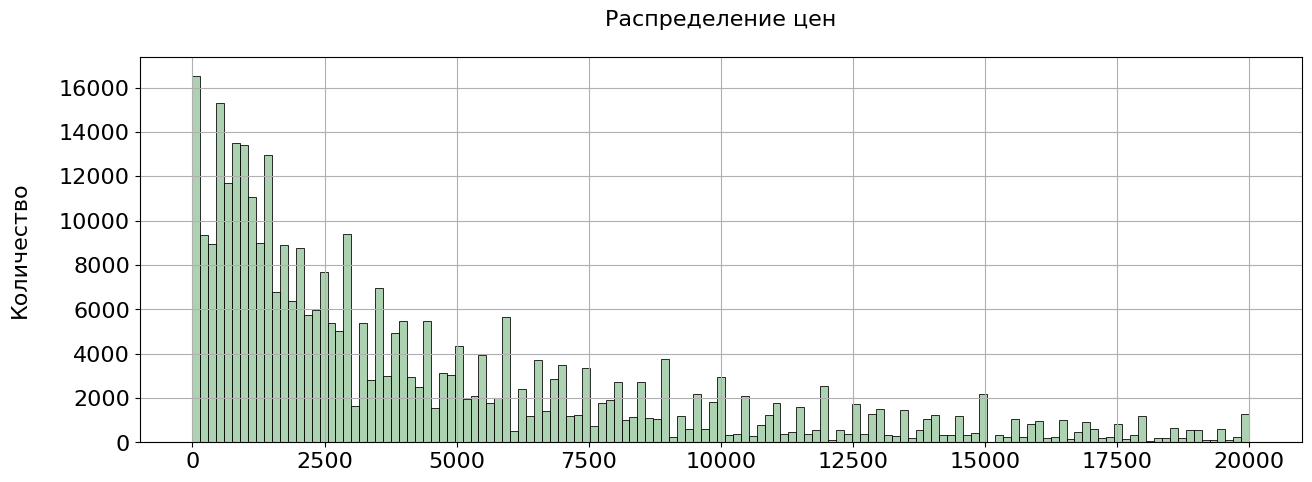

In [17]:
plt.figure(figsize=figsize(3))
ax = sns.histplot(df['Price'],color=new_color(),alpha=alpha)
plot_set(ax,title='Распределение цен', ylabel='Количество', xrot=False)

Наблюдаются особенности. Есть много значений около `0` и равных `0`, от них нужно будет избавиться. Так же есть много очень высоких цен. 

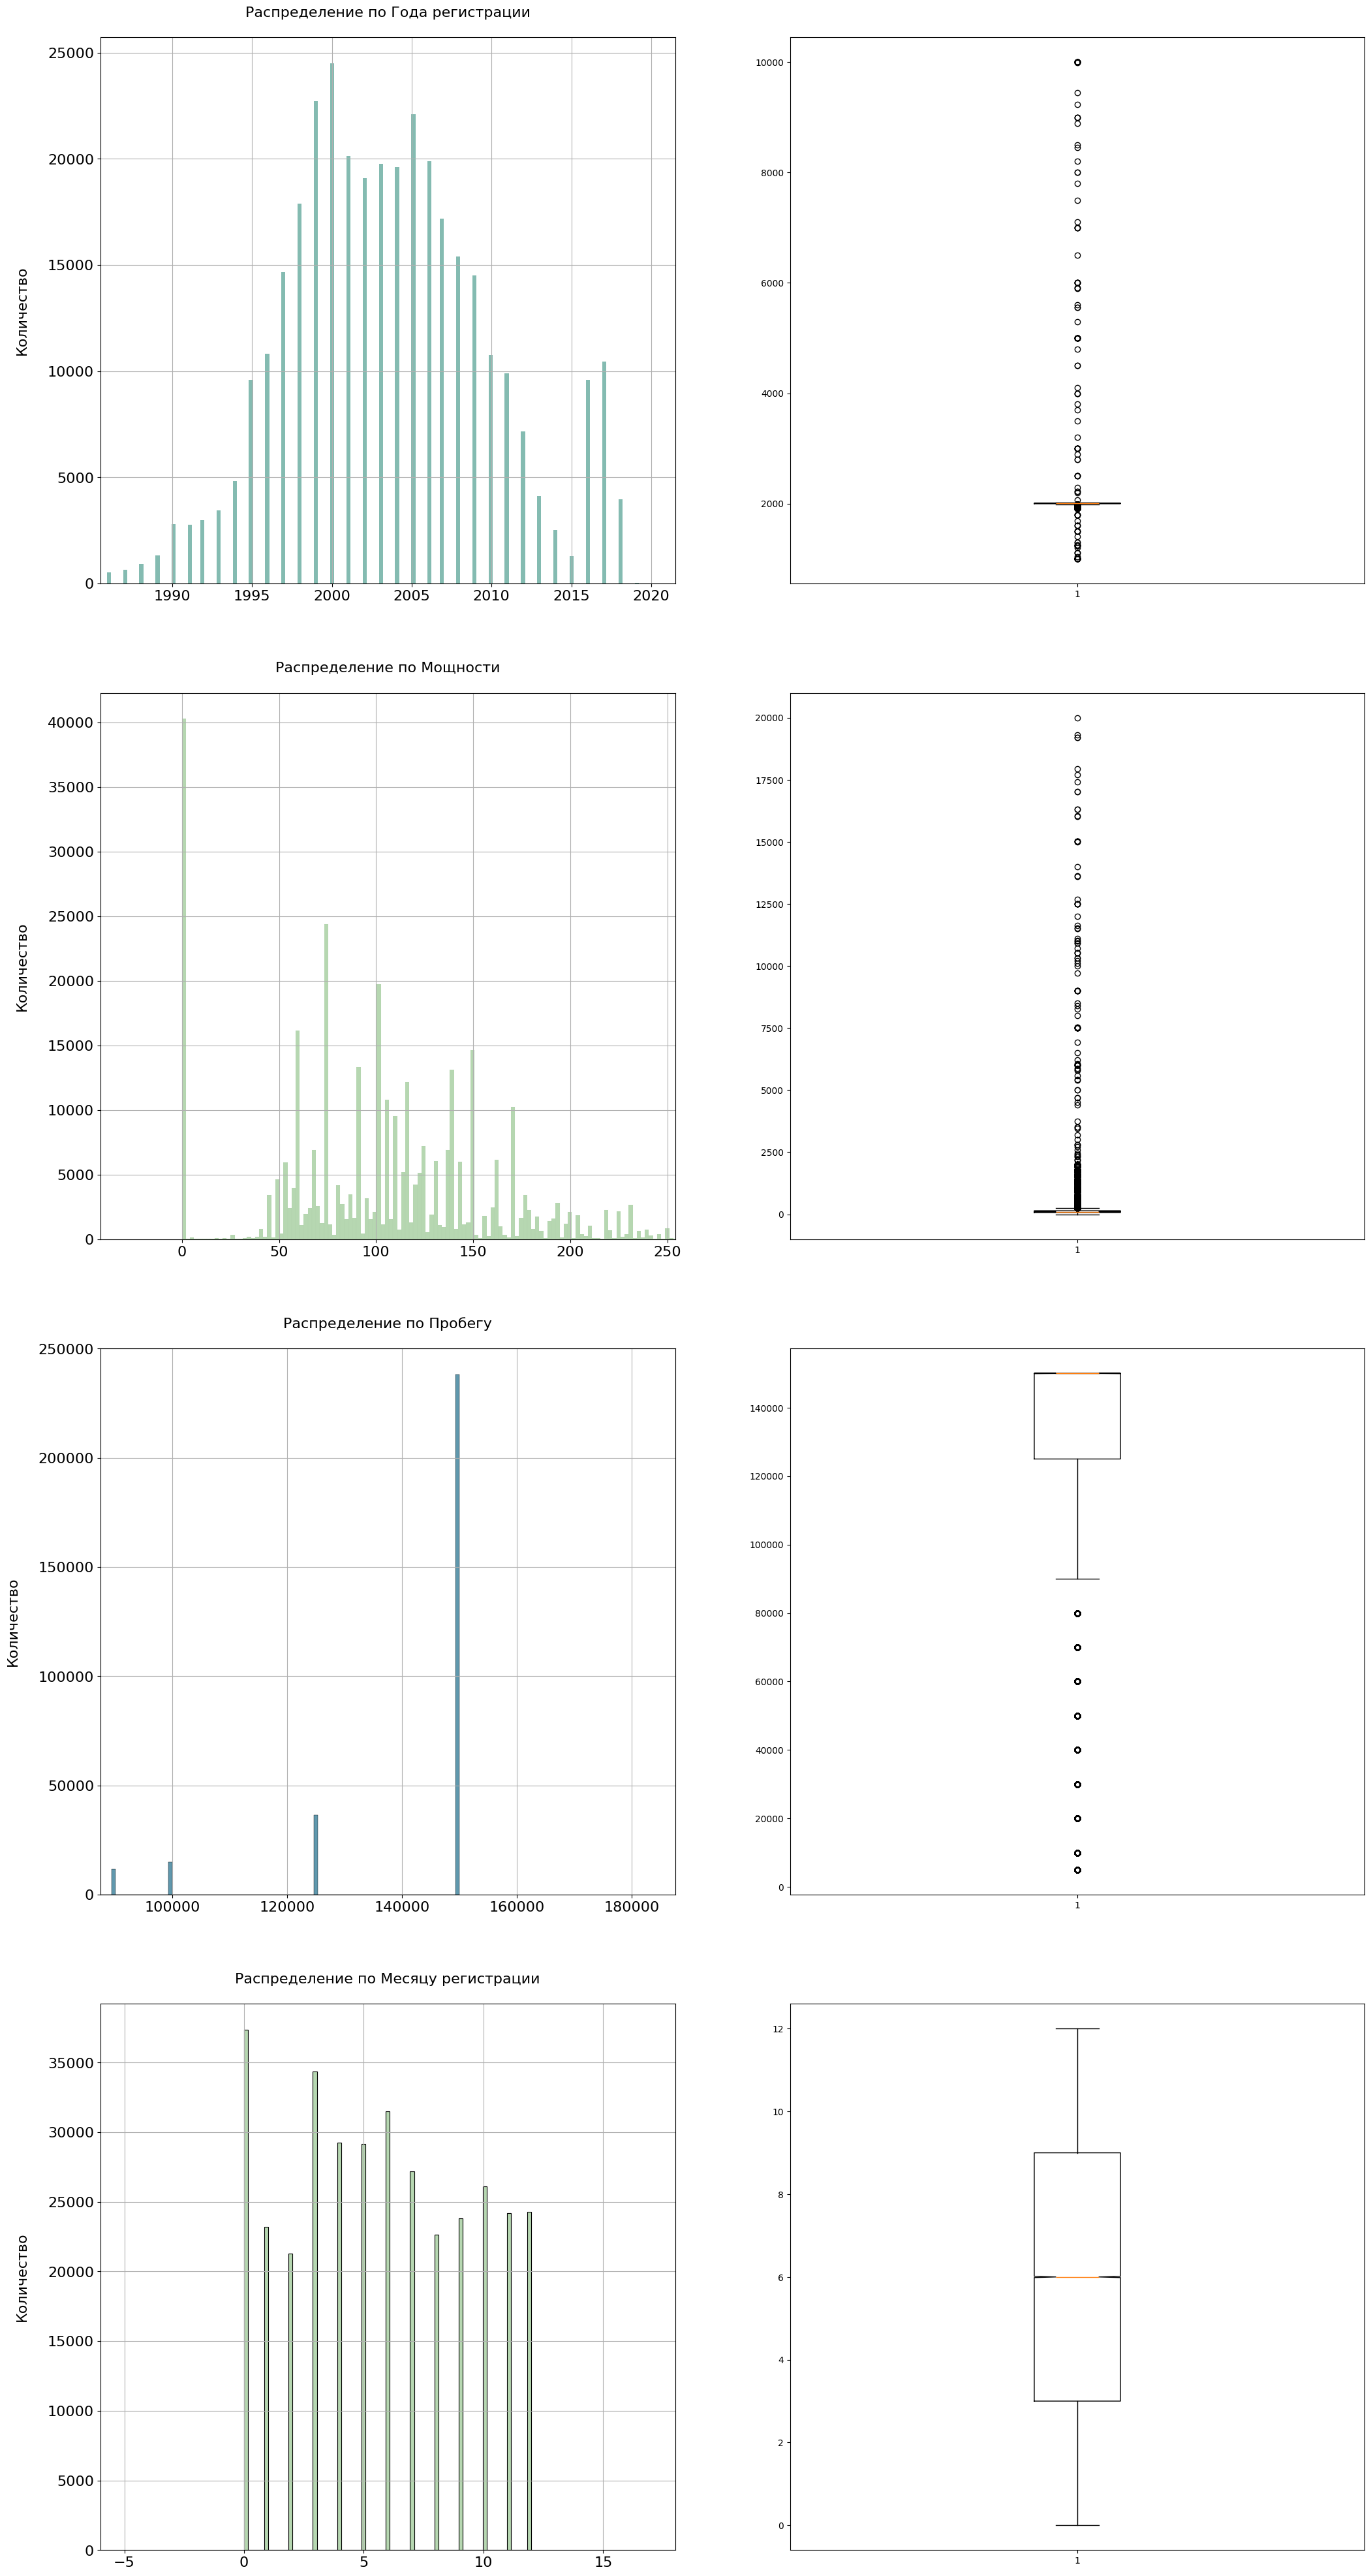

In [18]:
plt.figure(figsize=figsize(5,10))
for t in range(len(num_columns)):
    ax1 = plt.subplot(len(num_columns),2,2*t+1)
    sns.histplot(df[num_columns[t]],color=new_color(),alpha=alpha,ax=ax1)
    plt.xlim(x_lims[t])
    plot_set(ax1,title='Распределение по '+num_columns_name[t],ylabel='Количество',xrot=False)
    plt.subplot(len(num_columns),2,2*t+2)
    plt.boxplot(df[num_columns[t]],notch=True)

Наблюдается очень много аномалий практически во всех столбцах. Их необходимо обработать.

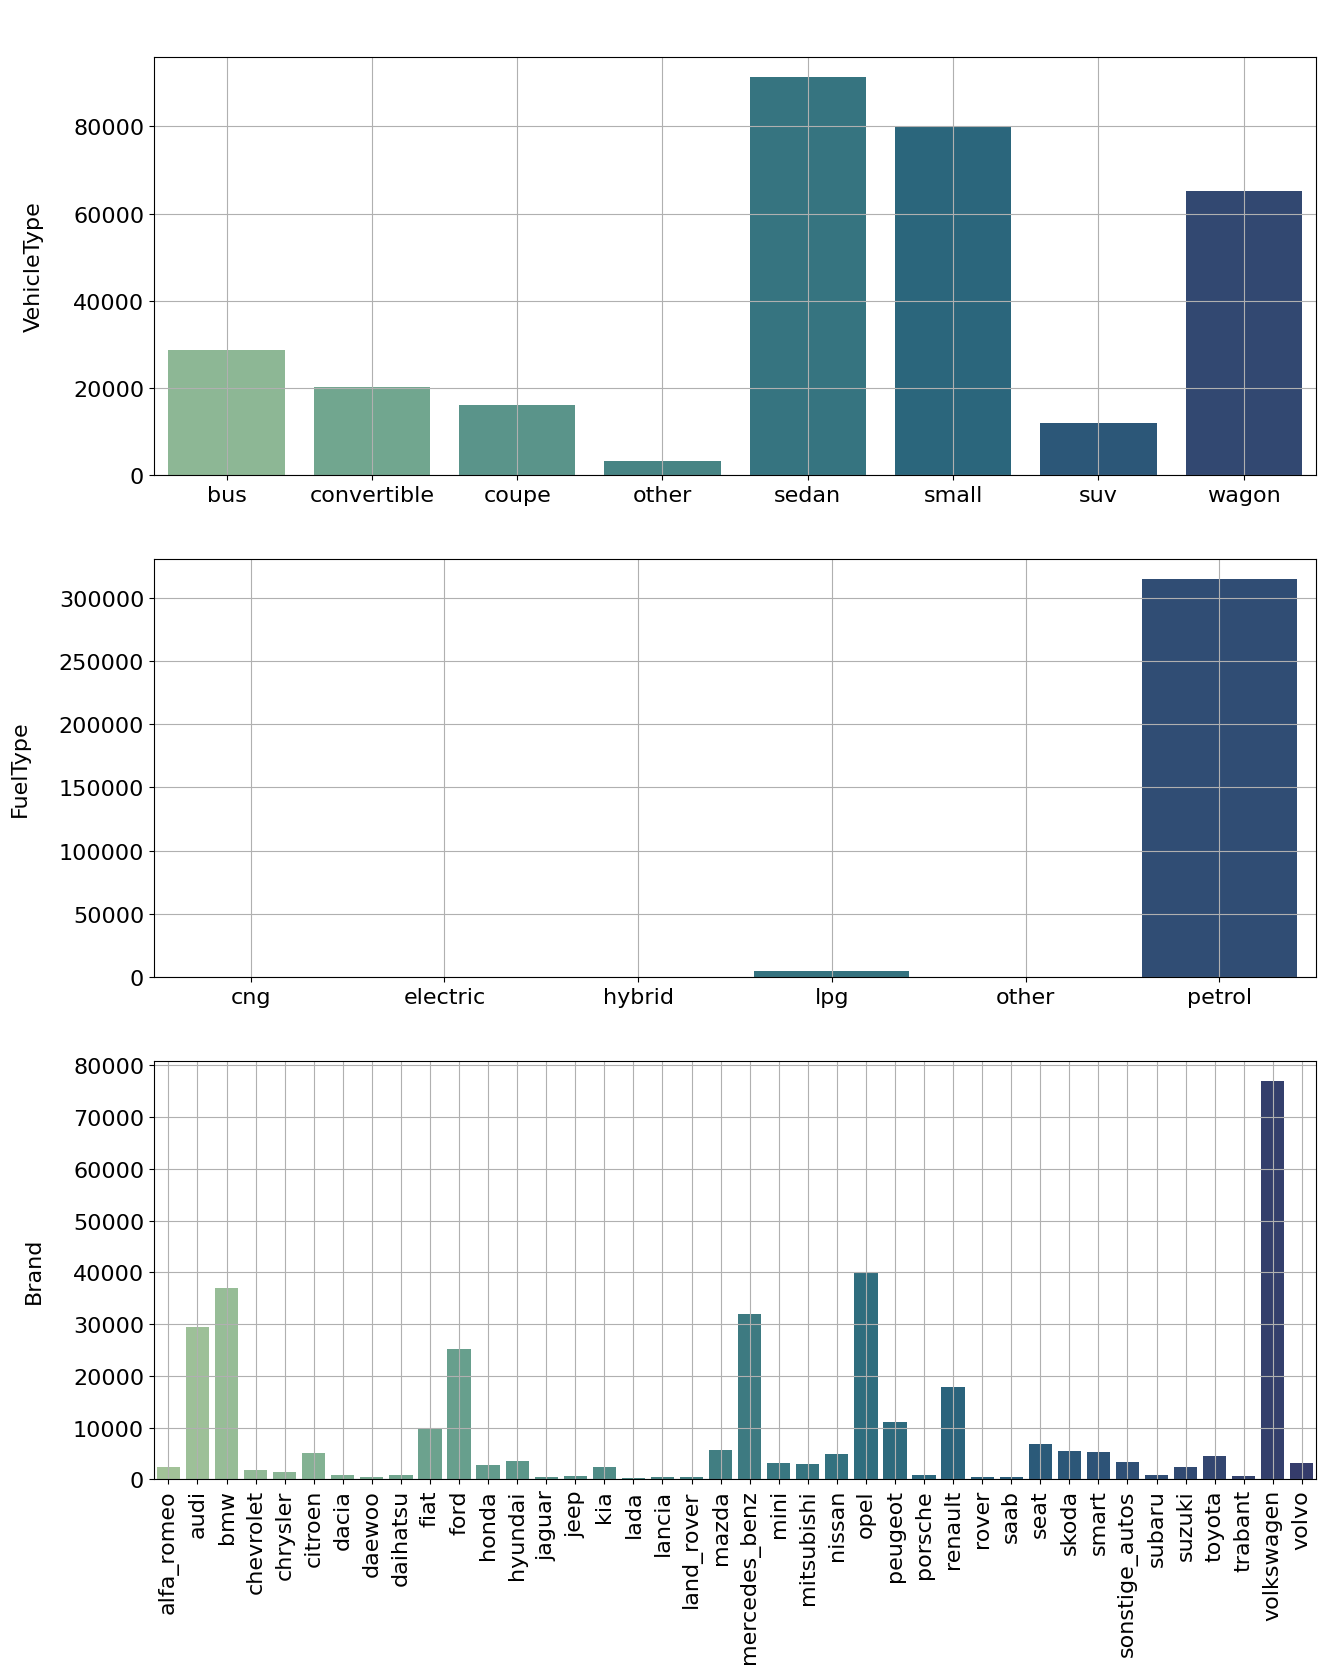

In [19]:
plt.figure(figsize=figsize(3,5))
for t in range(len(cat_columns)-1):
    plt.subplot(len(cat_columns),1,t+1)
    pivot = df.pivot_table(index=cat_columns[t], values='Price', aggfunc='count')
    ax = sns.barplot(x=pivot.index, y='Price', data=pivot, palette=cm)
    plot_set(ax,ylabel=cat_columns[t],xrot=(t==len(cat_columns)-2))

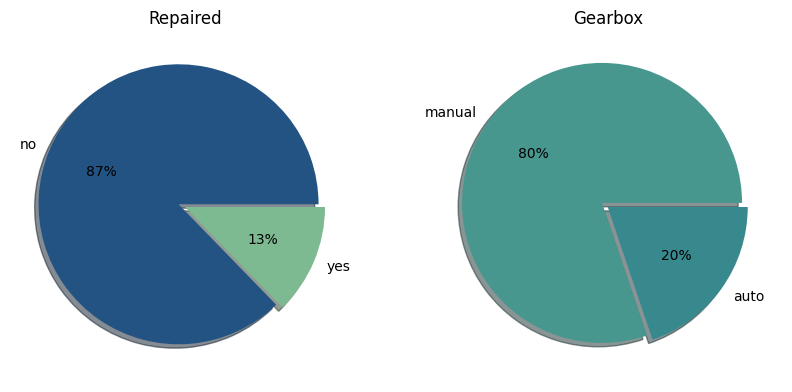

In [20]:
plt.figure(figsize=figsize(2,2))
for t in range(len(bool_columns)):
    plt.subplot(len(bool_columns),2,t+1)
    df[bool_columns[t]].value_counts().plot(
    kind = 'pie',
    autopct = '%1.0f%%',
    title = bool_columns[t],
    colors=[new_color(),new_color()],explode = (0.05,0), shadow=True);
    plt.ylabel('')
None

Почти везде можно найти сильно преобладающее значение.

### Обработка пропусков

In [21]:
df.isna().mean().sort_values().apply(mean_percent)

Price                 0.00%
RegistrationYear      0.00%
Power                 0.00%
Kilometer             0.00%
RegistrationMonth     0.00%
Brand                 0.00%
Model                 5.56%
Gearbox               5.60%
FuelType              9.28%
VehicleType          10.58%
Repaired             20.08%
dtype: object

#### VehicleType

In [22]:
for t in df.loc[df['VehicleType'].isna(),'Model'].unique()[0:2]:
    if ~df.loc[(df['Model'] == t), 'VehicleType'].isna().all():
        print('Model:', t)
        print(df.loc[(df['Model'] == t) & (df['VehicleType'].notna()), 'VehicleType'].value_counts())

Model: golf
VehicleType
sedan          14744
small           3911
wagon           3181
convertible     1962
bus              760
coupe            429
other            185
suv               25
Name: count, dtype: int64
Model: polo
VehicleType
small          10267
sedan            612
wagon            292
coupe            265
other             23
convertible        3
bus                2
suv                2
Name: count, dtype: int64


Зная только модель, тип кузова определить не получится. Заменим данные на `unknown`

In [23]:
df['VehicleType']=df['VehicleType'].fillna('unknown')

#### FuelType

In [24]:
for t in df.loc[df['FuelType'].isna(),'Model'].unique()[0:3]:
    if ~df.loc[(df['Model'] == t), 'FuelType'].isna().all():
        print('Model:', t)
        print(df.loc[(df['Model'] == t) & (df['FuelType'].notna()), 'FuelType'].value_counts())

Model: golf
FuelType
petrol      26595
lpg           172
cng            23
other           8
electric        3
hybrid          1
Name: count, dtype: int64
Model: passat
FuelType
petrol    9177
lpg        139
cng         10
other        2
Name: count, dtype: int64
Model: c4
FuelType
petrol    411
lpg         8
Name: count, dtype: int64


По модели нельзя однозначно установить тип топлива. В подавляющем большинстве случаев тип топлива - бензин.

Если тип топлива не указан, скорее всего двигатель бензиновый

In [25]:
df['FuelType']=df['FuelType'].fillna('petrol')

#### Model

In [26]:
df[df['Model']=='other']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
24,500,sedan,1990,manual,118,other,150000,10,petrol,mercedes_benz,yes
38,11900,other,2002,manual,129,other,150000,11,petrol,volkswagen,no
39,1500,bus,1984,manual,70,other,150000,8,petrol,mercedes_benz,no
52,1400,unknown,2016,manual,55,other,5000,1,petrol,hyundai,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354290,2500,small,2007,manual,60,other,125000,3,petrol,hyundai,NaN
354302,5990,bus,1984,auto,0,other,70000,4,petrol,chevrolet,NaN
354316,3300,coupe,1957,manual,40,other,100000,11,petrol,trabant,no
354325,12800,convertible,1991,manual,211,other,150000,7,petrol,porsche,no


In [27]:
df.loc[df['Model'].isna(),'Brand'].unique()

array(['audi', 'sonstige_autos', 'fiat', 'volkswagen', 'renault', 'bmw',
       'mitsubishi', 'peugeot', 'alfa_romeo', 'volvo', 'toyota',
       'chevrolet', 'trabant', 'saab', 'opel', 'mercedes_benz', 'smart',
       'nissan', 'skoda', 'ford', 'kia', 'suzuki', 'hyundai', 'seat',
       'mazda', 'citroen', 'chrysler', 'porsche', 'land_rover', 'daewoo',
       'lancia', 'honda', 'rover', 'mini', 'dacia', 'jaguar', 'daihatsu',
       'lada', 'subaru', 'jeep'], dtype=object)

In [28]:
for t in df.loc[df['Model'].isna(),'Brand'].unique()[0:3]:
    if ~df.loc[(df['Brand'] == t), 'Model'].isna().all():
        print(df.loc[df['Brand'] == t, 'Model'].value_counts())

Model
a4       9900
a3       6122
a6       5541
80       1604
tt       1076
other    1033
a1        595
a5        545
a8        529
100       417
a2        373
q7        205
90        103
q5         97
200        18
q3         15
Name: count, dtype: int64
Model
punto       3347
other       1789
500          920
panda        676
seicento     670
stilo        603
ducato       435
bravo        331
doblo        325
croma         45
Name: count, dtype: int64


Только по бренду не получится восстановить марку машины. Так как в выборке уже присутствует вариант `other`, заменим отсутствующие значения на него.

In [29]:
df['Model']=df['Model'].fillna('other')

#### Gearbox

Большинство машин с механической коробкой передач.Если бы автомобиль был с автоматической, скорее всего это указали бы явно.

In [30]:
df['Gearbox']=df['Gearbox'].fillna('manual')

#### Repaired

Большинство машин не были в ремонте. Если бы ремонт был (или о нём хотели сказать и за счёт этого снизить цену), но был бы указан. Пропуски можно заменить ответом нет

In [31]:
df['Repaired']=df['Repaired'].fillna('no')

In [32]:
df.isna().mean().sort_values().apply(mean_percent)

Price                0.00%
VehicleType          0.00%
RegistrationYear     0.00%
Gearbox              0.00%
Power                0.00%
Model                0.00%
Kilometer            0.00%
RegistrationMonth    0.00%
FuelType             0.00%
Brand                0.00%
Repaired             0.00%
dtype: object

### Обработка аномалий

#### Цена

Исключим из рассмотрения аномально низкие цены.

In [33]:
df = df.query('Price> 10')

#### Мощноть

Исключим из рассмотрения аномально низкие и высокие мощности.

In [36]:
df=df.query('Power > 15 & Power < 1000')

#### Год регистрации

Исключим из рассмотрения аномальные значения года регистрации.

In [37]:
df=df.query('RegistrationYear >= 1950 & RegistrationYear < 2017')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295587 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              295587 non-null  int64 
 1   VehicleType        295587 non-null  object
 2   RegistrationYear   295587 non-null  int64 
 3   Gearbox            295587 non-null  object
 4   Power              295587 non-null  int64 
 5   Model              295587 non-null  object
 6   Kilometer          295587 non-null  int64 
 7   RegistrationMonth  295587 non-null  int64 
 8   FuelType           295587 non-null  object
 9   Brand              295587 non-null  object
 10  Repaired           295587 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.1+ MB


### Вывод этапа

- Удалены дубликаты;
- Удалины столбцы `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`,`PostalCode`;
- Изменено значение `gasoline` на `petrol` в столбце `FuelType`, поскольку это один и тот же тип топлива;
- Наблюдается очень много аномалий практически во всех столбцах:
    - Исключины из рассмотрения аномально низкие цены.
    - Исключины из рассмотрения аномально низкие и высокие мощности.
    - Исключины из рассмотрения аномальные значения года регистрации.
- Обработаны пропуски:
    - Зная только модель, тип кузова определить не получится. Замени\ены данные на `unknown`;
    - По модели нельзя однозначно установить тип топлива. В подавляющем большинстве случаев тип топлива - бензин;
    - Только по бренду не получится восстановить марку машины. Так как в выборке уже присутствует вариант `other`, заменили отсутствующие значения на него;
    - Большинство машин с механической коробкой передач.Если бы автомобиль был с автоматической, скорее всего это указали бы явно;
    - Большинство машин не были в ремонте. Если бы ремонт был (или о нём хотели сказать и за счёт этого снизить цену), но был бы указан. Пропуски можно заменить ответом `no`.

## Обучение моделей

### Подготовка данных

Выделим целевой признак.

In [39]:
features = df.drop('Price', axis=1)
target = df['Price']
features_train, features_test, target_train, target_test = train_test_split(
        features, target,
        test_size=0.25,
        random_state=RANDOM_STATE)

print("Размер обучающей выборки:", features_train.shape, 
      "\nРазмер тестовой выборки:",features_test.shape)

Размер обучающей выборки: (221690, 10) 
Размер тестовой выборки: (73897, 10)


Масштабируем данные.

In [40]:
scaler = StandardScaler()
scaler.fit(features_train[num_columns])
None

In [41]:
features_train[num_columns] = scaler.transform(features_train[num_columns])
features_test[num_columns] = scaler.transform(features_test[num_columns])

In [42]:
max_model_num = features['Model'].value_counts().count()

Обработаем категориальные переменные.

In [43]:
categorial = cat_columns + bool_columns
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = max_model_num )
encoder.fit(features_train[categorial])
None


Здесь не знаю как обойти проблему кодирования. В тестовую выборку попадают модели, которых не было в обучающей. Соответственно, они не могут быть корректно обработаны. Сделал обучение на всей выборке, но это кажется не очень правильным.

Вообще возникает вопрос, насколько может быть полезна информация о модели, если она во всей выборке встречается всего один или два раза. Большая вероятность, что модель не обучится на них, а за счёт кодирования какой нибудь результат выдаст. 

Кажется, что OHE тут рациональнее бы сработал, но свой столбец на каждую модель как то слишком много получается, пугает. 

In [44]:
features_train[categorial] = encoder.transform(features_train[categorial])
features_test[categorial] = encoder.transform(features_test[categorial])

In [45]:
features_train.head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
35944,4.0,-1.982169,1.0,-0.381220,11.0,-1.045287,-1.394688,5.0,2.0,1.0
264564,8.0,-0.593697,1.0,0.537006,29.0,0.591293,-0.557144,5.0,1.0,0.0
308159,5.0,-0.593697,1.0,-1.115801,173.0,0.591293,-0.836325,5.0,38.0,0.0
125599,8.0,0.177677,1.0,1.032848,204.0,0.591293,-1.115506,5.0,24.0,0.0
330691,4.0,0.486226,1.0,0.408454,6.0,-2.409104,0.001219,5.0,2.0,0.0
311980,5.0,1.411874,1.0,-0.840334,226.0,-2.409104,-0.557144,5.0,27.0,0.0
345740,4.0,0.794775,1.0,-0.087388,28.0,-0.090616,-0.557144,5.0,1.0,0.0
50030,6.0,0.331951,1.0,0.353361,208.0,0.591293,0.559582,5.0,15.0,0.0
333511,2.0,-1.056521,1.0,0.463548,11.0,0.591293,-0.557144,5.0,2.0,1.0
18285,2.0,-0.902246,1.0,0.775745,166.0,0.591293,-1.673869,5.0,5.0,0.0


Зададим функцию для поиска оптимальных гипперпараметров.

In [46]:
def objective(trial,features=features_train,target=target_train):
    if model_type == 'tree':
        param = {
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 7),
            'max_depth': trial.suggest_int('max_depth', 1, 100),
        }

        # создаем модель
        model = DecisionTreeRegressor(**param, random_state=RANDOM_STATE)
        
    elif model_type == 'random_forest':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_depth': trial.suggest_int('max_depth', 1, 60),
        }

        # создаем модель
        model = RandomForestRegressor(**param, random_state=RANDOM_STATE)
        
    elif model_type == 'svm':
        param = {
            'kernel': trial.suggest_categorical('kernel', ['rbf']),
            'C': trial.suggest_float('C', 1e-2, 1e2,log=True),
            'gamma': trial.suggest_float('gamma', 1e-3, 1e3,log=True)
        }

        # создаем модель
        model = svm.SVR(**param)
        
    elif model_type == 'xg_boost':
        param = {
            #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0,log=True),
            #'alpha': trial.suggest_float('alpha', 1e-3, 10.0,log=True),
            #'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            #'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.018, 0.02]),
            #'n_estimators': 300,
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        model = xgb.XGBRegressor(**param, random_state=RANDOM_STATE)
        
    elif model_type == 'cat_boost':
        param = {
            #'loss_function': 'RMSE',
            'verbose' : False,
            #'task_type': 'GPU',
            #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0,log=True),
            #'max_bin': trial.suggest_int('max_bin', 200, 400),
            #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
            #'subsample': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            #'learning_rate': trial.suggest_float('learning_rate', 0.006, 0.018),
            'n_estimators': trial.suggest_int('n_estimators', 800, 1200),
            'max_depth': trial.suggest_int('max_depth', 5, 16),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        }
        model = CatBoostRegressor(**param, random_state=RANDOM_STATE)
    
    elif model_type == 'light_GBM':
        
        param = {
            'num_leaves': trial.suggest_categorical('num_leaves', [25, 50, 100, 200]), 
            'learning_rate': trial.suggest_float('learning_rate', .1, .5)
        }
            
        model = LGBMRegressor(**param, random_state=RANDOM_STATE)
        
    score = cross_val_score(model, features, target, cv = 3, scoring='neg_root_mean_squared_error', n_jobs = 2).mean()
    
    return -score

### Обучение моделей

Рассмотрим модели:
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `XGBRegressor`
- `CatBoostRegressor`
- `LGBMRegressor`

In [47]:
optimization_time = []

In [48]:
start_time = time.time()
model_type = 'tree'
study_tree = optuna.create_study(study_name="Tree",
                                   direction="minimize"
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_tree.optimize(objective, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_tree.best_params))
print("RMSE: {:.2f}".format(study_tree.best_value))

params_tree = study_tree.best_params
score_tree = study_tree.best_value

end_time = time.time()
optimization_time.append(end_time - start_time)
print("Время поиска гиперпараметров {}".format(end_time - start_time))

[I 2023-11-15 19:46:00,956] A new study created in memory with name: Tree
[I 2023-11-15 19:46:03,757] Trial 0 finished with value: 1872.0303776126405 and parameters: {'min_samples_leaf': 4, 'max_depth': 33}. Best is trial 0 with value: 1872.0303776126405.
[I 2023-11-15 19:46:05,187] Trial 1 finished with value: 1844.998419382824 and parameters: {'min_samples_leaf': 6, 'max_depth': 84}. Best is trial 1 with value: 1844.998419382824.
[I 2023-11-15 19:46:05,955] Trial 2 finished with value: 2096.8723926883827 and parameters: {'min_samples_leaf': 5, 'max_depth': 8}. Best is trial 1 with value: 1844.998419382824.
[I 2023-11-15 19:46:07,051] Trial 3 finished with value: 1897.8236109177622 and parameters: {'min_samples_leaf': 2, 'max_depth': 13}. Best is trial 1 with value: 1844.998419382824.
[I 2023-11-15 19:46:08,843] Trial 4 finished with value: 1967.597335037303 and parameters: {'min_samples_leaf': 2, 'max_depth': 25}. Best is trial 1 with value: 1844.998419382824.
[I 2023-11-15 19:46:10,

Наилучшие значения гиперпараметров {'min_samples_leaf': 7, 'max_depth': 65}
RMSE: 1834.80
Время поиска гиперпараметров 15.526549577713013


In [49]:
start_time = time.time()
model_type = 'random_forest'
study_random_forest = optuna.create_study(study_name="random_forest",
                                   direction="minimize"
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_random_forest.optimize(objective, n_trials=5)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_random_forest.best_params))
print("RMSE: {:.2f}".format(study_random_forest.best_value))

params_random_forest = study_random_forest.best_params
score_random_forest = study_random_forest.best_value

end_time = time.time()
optimization_time.append(end_time - start_time)
print("Время поиска гиперпараметров {}".format(end_time - start_time))

[I 2023-11-15 19:46:16,488] A new study created in memory with name: random_forest
[I 2023-11-15 19:47:20,873] Trial 0 finished with value: 1629.0826154529107 and parameters: {'n_estimators': 82, 'min_samples_leaf': 1, 'max_depth': 16}. Best is trial 0 with value: 1629.0826154529107.
[I 2023-11-15 19:47:30,907] Trial 1 finished with value: 3188.898705768823 and parameters: {'n_estimators': 93, 'min_samples_leaf': 5, 'max_depth': 2}. Best is trial 0 with value: 1629.0826154529107.
[I 2023-11-15 19:49:19,718] Trial 2 finished with value: 1619.0335456693117 and parameters: {'n_estimators': 136, 'min_samples_leaf': 4, 'max_depth': 22}. Best is trial 2 with value: 1619.0335456693117.
[I 2023-11-15 19:50:25,100] Trial 3 finished with value: 1609.281883959408 and parameters: {'n_estimators': 62, 'min_samples_leaf': 2, 'max_depth': 29}. Best is trial 3 with value: 1609.281883959408.
[I 2023-11-15 19:51:21,364] Trial 4 finished with value: 1621.068631002225 and parameters: {'n_estimators': 69, 

Наилучшие значения гиперпараметров {'n_estimators': 62, 'min_samples_leaf': 2, 'max_depth': 29}
RMSE: 1609.28
Время поиска гиперпараметров 304.8759491443634


In [50]:
start_time = time.time()
model_type = 'xg_boost'
study_xg_boost = optuna.create_study(study_name="xg_boost",
                                   direction="minimize"
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_xg_boost.optimize(objective, n_trials=5)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_xg_boost.best_params))
print("RMSE: {:.2f}".format(study_xg_boost.best_value))

#params_xg_boost = {'lambda': 0.0048892141030954465, 'max_depth': 10}
#score_xg_boost = 1603.86

params_xg_boost = study_xg_boost.best_params
score_xg_boost = study_xg_boost.best_value

end_time = time.time()
optimization_time.append(end_time - start_time)
print("Время поиска гиперпараметров {}".format(end_time - start_time))

[I 2023-11-15 19:51:21,372] A new study created in memory with name: xg_boost
[I 2023-11-15 19:51:22,631] Trial 0 finished with value: 1667.0996291214287 and parameters: {'lambda': 0.06339866256547615, 'max_depth': 5}. Best is trial 0 with value: 1667.0996291214287.
[I 2023-11-15 19:51:25,257] Trial 1 finished with value: 1607.5729540728778 and parameters: {'lambda': 0.003021962341845584, 'max_depth': 10}. Best is trial 1 with value: 1607.5729540728778.
[I 2023-11-15 19:51:26,763] Trial 2 finished with value: 1602.7550398409605 and parameters: {'lambda': 0.018638583717699005, 'max_depth': 7}. Best is trial 2 with value: 1602.7550398409605.
[I 2023-11-15 19:51:28,723] Trial 3 finished with value: 1573.2929845360177 and parameters: {'lambda': 2.736525958710595, 'max_depth': 9}. Best is trial 3 with value: 1573.2929845360177.
[I 2023-11-15 19:51:30,032] Trial 4 finished with value: 1628.7730267727923 and parameters: {'lambda': 0.7484043649082224, 'max_depth': 6}. Best is trial 3 with valu

Наилучшие значения гиперпараметров {'lambda': 2.736525958710595, 'max_depth': 9}
RMSE: 1573.29
Время поиска гиперпараметров 8.659746646881104


In [51]:
start_time = time.time()
model_type = 'cat_boost'
study_cat_boost = optuna.create_study(study_name="Cat_boost",
                                   direction="minimize"
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_cat_boost.optimize(objective, n_trials=3)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_cat_boost.best_params))
print("RMSE: {:.2f}".format(study_cat_boost.best_value))

#params_cat_boost = {'n_estimators': 1000, 'max_depth': 11}
#score_cat_boost = 1550.89

params_cat_boost = study_cat_boost.best_params
score_cat_boost = study_cat_boost.best_value

end_time = time.time()
optimization_time.append(end_time - start_time)
print("Время поиска гиперпараметров {}".format(end_time - start_time))

[I 2023-11-15 19:51:30,040] A new study created in memory with name: Cat_boost
[I 2023-11-15 19:52:03,903] Trial 0 finished with value: 1618.0334879125712 and parameters: {'n_estimators': 1122, 'max_depth': 6}. Best is trial 0 with value: 1618.0334879125712.
[I 2023-11-15 20:01:18,431] Trial 1 finished with value: 1547.439260534981 and parameters: {'n_estimators': 1172, 'max_depth': 14}. Best is trial 1 with value: 1547.439260534981.
[I 2023-11-15 20:14:53,478] Trial 2 finished with value: 1554.7598005056013 and parameters: {'n_estimators': 864, 'max_depth': 15}. Best is trial 1 with value: 1547.439260534981.


Наилучшие значения гиперпараметров {'n_estimators': 1172, 'max_depth': 14}
RMSE: 1547.44
Время поиска гиперпараметров 1403.4384059906006


In [52]:
start_time = time.time()
model_type = 'light_GBM'
study_light_GBM = optuna.create_study(study_name="light_GBM",
                                   direction="minimize"
                                   )
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_light_GBM.optimize(objective, n_trials=5)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_light_GBM.best_params))
print("RMSE: {:.2f}".format(study_light_GBM.best_value))

#params_light_GBM = {'num_leaves': 200, 'learning_rate': 0.12059023673706504}
#score_light_GBM = 1569.66

params_light_GBM = study_light_GBM.best_params
score_light_GBM = study_light_GBM.best_value

end_time = time.time()
optimization_time.append(end_time - start_time)
print("Время поиска гиперпараметров {}".format(end_time - start_time))

[I 2023-11-15 20:14:53,482] A new study created in memory with name: light_GBM
[I 2023-11-15 20:14:55,465] Trial 0 finished with value: 1648.8393213377246 and parameters: {'num_leaves': 25, 'learning_rate': 0.4827692951923527}. Best is trial 0 with value: 1648.8393213377246.
[I 2023-11-15 20:14:57,714] Trial 1 finished with value: 1594.3350741404781 and parameters: {'num_leaves': 200, 'learning_rate': 0.40748734118266694}. Best is trial 1 with value: 1594.3350741404781.
[I 2023-11-15 20:14:59,072] Trial 2 finished with value: 1612.4984976782782 and parameters: {'num_leaves': 50, 'learning_rate': 0.2329757091356459}. Best is trial 1 with value: 1594.3350741404781.
[I 2023-11-15 20:15:01,389] Trial 3 finished with value: 1570.847752330641 and parameters: {'num_leaves': 200, 'learning_rate': 0.26113099362424275}. Best is trial 3 with value: 1570.847752330641.
[I 2023-11-15 20:15:02,669] Trial 4 finished with value: 1695.3693729357017 and parameters: {'num_leaves': 25, 'learning_rate': 0.1

Наилучшие значения гиперпараметров {'num_leaves': 200, 'learning_rate': 0.26113099362424275}
RMSE: 1570.85
Время поиска гиперпараметров 9.188294410705566


### Вывод этапа

Рассмотрены модели:
- `DecisionTreeRegressor`
    - Время поиска параметров 16 секунд, 
    - `MRSE` - 1830
- `RandomForestRegressor`
    - Время поиска параметров 305 секунд, 
    - `MRSE` - 1570
- `XGBRegressor`
    - Время поиска параметров 8 секунд, 
    - `MRSE` - 1610
- `CatBoostRegressor`
    - Время поиска параметров 1400 секунд, 
    - `MRSE` - 1550
- `LGBMRegressor`
    - Время поиска параметров 9 секунд, 
    - `MRSE` - 1570
    
- MRSE всех моделей меньше чем требуемая 2500 евро;

## Анализ моделей

In [53]:
models = ['tree', 'random_forest', 'xg_boost', 'cat_boost', 'light_GBM']
#params = [params_tree, params_random_forest, params_xg_boost, params_cat_boost, params_light_GBM]
scores = [score_tree, score_random_forest, score_xg_boost, score_cat_boost, score_light_GBM]
params = {'tree': params_tree, 'random_forest': params_random_forest, 
             'xg_boost': params_xg_boost, 'cat_boost': params_cat_boost, 
             'light_GBM': params_light_GBM}

fit time tree: 0.8096973896026611
predict time tree: 0.0666964054107666

fit time random_forest: 47.170799255371094
predict time random_forest: 3.626164674758911

fit time xg_boost: 0.8559737205505371
predict time xg_boost: 0.14280152320861816

fit time cat_boost: 266.5745623111725
predict time cat_boost: 0.5776817798614502

fit time light_GBM: 0.9342567920684814
predict time light_GBM: 0.34094738960266113



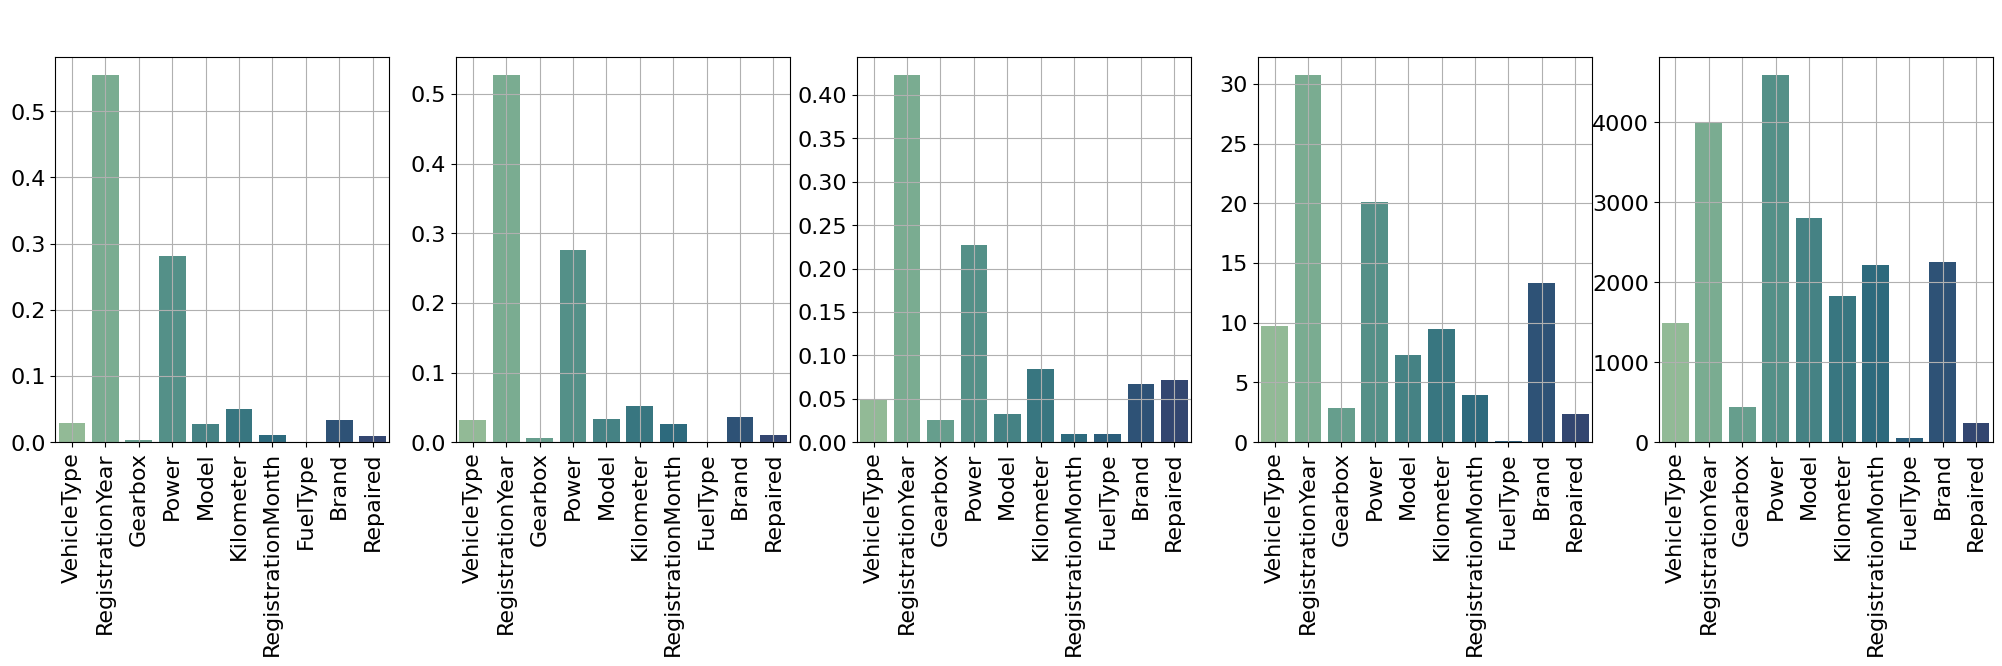

In [54]:
training_time = []
predict_time = []
i =  1
plt.figure(figsize=figsize(5))
for m in models:
    if m == 'tree':
        model = DecisionTreeRegressor(**params[m], random_state=RANDOM_STATE)
    elif m == 'random_forest':
            model = RandomForestRegressor(**params[m], random_state=RANDOM_STATE)
    elif m == 'xg_boost':
            model = xgb.XGBRegressor(**params[m], random_state=RANDOM_STATE)
    elif m == 'cat_boost':
            model = CatBoostRegressor(**params[m], random_state=RANDOM_STATE,verbose=False)
    elif m == 'light_GBM':
            model = LGBMRegressor(**params[m], random_state=RANDOM_STATE,verbose=0)
    
    start_time = time.time()
    model.fit(features_train,target_train)
    end_time = time.time()
    training_time.append(end_time - start_time)
    print('fit time '+m+":",end_time - start_time)
    
    start_time = time.time()
    model.predict(features_train)
    end_time = time.time()
    predict_time.append(end_time - start_time)
    print('predict time '+m+":",end_time - start_time)
    print()

    plt.subplot(1,len(models),i)
    feature_importances = pd.DataFrame(model.feature_importances_,index = features.columns, columns = ['feature'])
    ax = sns.barplot(data=feature_importances, x=feature_importances.index, y='feature', palette=cm)
    plot_set(ax)
    i += 1

In [55]:
data_metrics = pd.DataFrame({'MRSE': scores,
                             'Fit': training_time,
                             'Predict': predict_time,
                             'Search': optimization_time,
                           })
data_metrics.index=models
data_metrics.style.background_gradient(cmap=cm)

,MRSE,Fit,Predict,Search
tree,1834.804334,0.809697,0.066696,15.526550
random_forest,1609.281884,47.170799,3.626165,304.875949
xg_boost,1573.292985,0.855974,0.142802,8.659747
cat_boost,1547.439261,266.574562,0.577682,1403.438406
light_GBM,1570.847752,0.934257,0.340947,9.188294


В качестве итоговой модели выберем `LGBMRegressor` как оптимальную по соотношению время/качество.

## Итоговая модель

In [56]:
best_model = 'light_GBM'
if best_model == 'tree':
    model = DecisionTreeRegressor(**params[m], random_state=RANDOM_STATE)
elif best_model == 'random_forest':
        model = RandomForestRegressor(**params[m], random_state=RANDOM_STATE)
elif best_model == 'xg_boost':
        model = xgb.XGBRegressor(**params[m], random_state=RANDOM_STATE)
elif best_model == 'cat_boost':
        model = CatBoostRegressor(**params[m], random_state=RANDOM_STATE,verbose=False)
elif best_model == 'light_GBM':
        model = LGBMRegressor(**params[m], random_state=RANDOM_STATE,verbose=0)
start_time = time.time()
model.fit(features_train,target_train)
end_time = time.time()
print('Fit time: ', end_time - start_time)

start_time = time.time()
predict_test = model.predict(features_test)
end_time = time.time()
print('Predict time: ', end_time - start_time)
MRSE_final = mean_squared_error(target_test, predict_test) ** .5
print('Final MRSE: ', MRSE_final)

Fit time:  0.8667001724243164
Predict time:  0.10938334465026855
Final MRSE:  1532.7802040958627


## Вывод

- Изучен датафрейм `Churn.csv`:
    - 16 столбцов:
        - `DateCrawled` - дата скачивания анкеты из базы;
        - `VehicleType` - тип автомобильного кузова;
        - `RegistrationYear` - год регистрации автомобиля;
        - `Gearbox` - тип коробки передач;
        - `Power` - мощность (л. с.);
        - `Model` - модель автомобиля;
        - `Kilometer` - пробег (км);
        - `RegistrationMonth` - месяц регистрации автомобиля;
        - `FuelType` - тип топлива;
        - `Brand` - марка автомобиля;
        - `Repaired` - была машина в ремонте или нет;
        - `DateCreated` - дата создания анкеты;
        - `NumberOfPictures` - количество фотографий автомобиля;
        - `PostalCode` - почтовый индекс владельца анкеты (пользователя);
        - `LastSeen` - дата последней активности пользователя;
        - `Price` - цена (евро);
    - 354369 строк
    - Пропуски в строках:
        - `Model` - `5.56%`;
        - `Gearbox` - `5.60%`;
        - `FuelType` - `9.28%`;
        - `VehicleType` - `10.58%`;
        - `Repaired` - `20.08%`;
    - Типы всех столбцов корректны
    - Удалены дубликаты;
    - Удалены столбцы `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`,`PostalCode`;
    - Изменено значение `gasoline` на `petrol` в столбце `FuelType`, поскольку это один и тот же тип топлива;
    - Наблюдается очень много аномалий практически во всех столбцах:
        - Исключины из рассмотрения аномально низкие цены;
        - Исключины из рассмотрения аномально низкие и высокие мощности;
        - Исключины из рассмотрения аномальные значения года регистрации;
    - Обработаны пропуски:
        - Зная только модель, тип кузова определить не получится. Замени\ены данные на `unknown`;
        - По модели нельзя однозначно установить тип топлива. В подавляющем большинстве случаев тип топлива - бензин;
        - Только по бренду не получится восстановить марку машины. Так как в выборке уже присутствует вариант `other`, заменили отсутствующие значения на него;
        - Большинство машин с механической коробкой передач.Если бы автомобиль был с автоматической, скорее всего это указали бы явно;
        - Большинство машин не были в ремонте. Если бы ремонт был (или о нём хотели сказать и за счёт этого снизить цену), но был бы указан. Пропуски можно заменить ответом `no`;
- Рассмотрены модели:
    - `DecisionTreeRegressor`
        - Время поиска параметров 14 секунд;
        - `MRSE` - 1830 евро;
        - Время обучения модели - 0.75 c;
        - Время предсказания модели - 0.05 c;
    - `RandomForestRegressor`
        - Время поиска параметров 7 минут;
        - `MRSE` - 1610 евро;
        - Время обучения модели - 47 c;
        - Время предсказания модели -3 c;
    - `XGBRegressor`
        - Время поиска параметров 10 минут;
        - `MRSE` - 1570 евро;
        - Время обучения модели - 1 c;
        - Время предсказания модели - 1 c;
    - `CatBoostRegressor`
        - Время поиска параметров 18 минут;
        - `MRSE` - 1550 евро;
        - Время обучения модели - 266 c;
        - Время предсказания модели - 1 c;
    - `LGBMRegressor`
        - Время поиска параметров 1 минута, ;
        - `MRSE` - 1570 евро;
        - Время обучения модели - 16 c;
        - Время предсказания модели - 3 c;
- MRSE всех моделей меньше чем требуемая 2500 евро;
- Наиболее важными признаками для предсказания цены являются `RegistrationYear` и `Power`;
- В качестве итоговой модели выбрана `LGBMRegressor` как оптимальная по соотношению время/качество;
    - Итоговое MRSE на тестовой выборке 1530 евро;
    - Время обучения менее секунды;
    - Время предсказания менее секунды.